In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gensim.models as models
import networkx as nx
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import os
import edgelist
from demo_utils import * 

# EmbDI: Embeddings for Data Integration

## Representing relational datasets as graphs.

In [2]:
%%time
# Reading the input dataset and preparing the edge list. 
dfpath = 'pipeline/datasets/imdb_movielens/imdb_movielens-master.csv'
df = pd.read_csv(dfpath)

edgefile = 'pipeline/experiments/imdb_movielens-edges.txt'
el = edgelist.EdgeList(df, edgefile)

In [2]:
g = nx.Graph()
edgefile = 'pipeline/experiments/imdb_movielens-edges.txt'

with open(edgefile, 'r') as fp:
    for idx, line in enumerate(fp):
        line = line.strip('')
        if len(line) == 0:
            continue
        n1,n2,w1,w2 = line.split(',')
        g.add_edge(n1, n2)        

# 100.0 - 49875/49875 tuples


In [17]:
# Printing the list of neighbors of an actor. 
print('Neighbors of orlando_bloom:')
print(list(g.neighbors('orlando_bloom')))
print()
print('Neighbors of idx_1:')
print(list(g.neighbors('idx_1')))


Neighbors of orlando_bloom:
['idx_1', 'actor_2', 'idx_12', 'idx_144', 'idx_198', 'idx_260', 'idx_265', 'idx_327', 'actor_1', 'idx_328', 'idx_387', 'actor_3', 'idx_864', 'idx_2471', 'idx_10913', 'idx_11742', 'idx_11814', 'idx_14533', 'idx_14740', 'idx_14973', 'idx_15529', 'idx_16348', 'idx_22247', 'idx_22362', 'idx_22490', 'idx_25179', 'idx_29148', 'idx_32301', 'idx_47410', 'idx_47947', 'idx_49464']

Neighbors of idx_1:
['johnny_depp', 'orlando_bloom', 'jack_davenport', 'color', 'pg13', 'gore_verbinski', 'english', 'usa', 'pirates_of_the_caribbean_at_worlds_end', '7', '2007']


"orlando_bloom" is present in multiple "actor" columns and in many different tuples. To show these tuples, we take a small subset and induce a subgraph by selecting all the nodes present in those tuples, as well as all the columns in the starting dataset. The dataset is built by combining two smaller datasets that contain 4.5k records and 45k records respectively. This means that idx_1 and idx_12 belong to dataset 1 (And therefore are linked to the columns in dataset 1), while idx_22247 belongs to dataset 2 and is connected to dataset 2's columns.  

As an example, we'll take a subset of the graph G by selecting only 3 tuples, corresponding to some of the movies Orlando Bloom starred in.


In [5]:
r1 = list(g.neighbors('idx_1'))
r2 = list(g.neighbors('idx_12'))
r3 = list(g.neighbors('idx_22247'))

nodes = r1 + r2 + r3 + list(df.columns) + ['idx_1', 'idx_12', 'idx_22247']

subg = g.subgraph(nodes)

left = ['idx_1', 'idx_12', 'idx_22247']
right = list(df.columns)
middle = r1 + r2 + r3
ll = tripartite(left,right,middle)

In [6]:
# Preparing the traces to plot in the picture. 
edge_x = []
edge_y = []

for edge in subg.edges:
    x0, y0 = ll[edge[0]]
    x1, y1 = ll[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)    

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in subg.nodes():
    x, y = ll[node]
    node_x.append(x)
    node_y.append(y)
    
    
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
#     text=node_text,
    marker=dict(
        showscale=True,
        colorscale='Blackbody',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Type',
            xanchor='left',
            titleside='right',
            tickvals=[-1, 1, 0],
            ticktext=['RID', 'CID', 'Node']
        ),
        line_width=2))

node_text = []
ns = list(subg.nodes())

node_colors = []
for node, val in enumerate(ns):
    if val in left:
        node_colors.append(-1)
    elif val in right:
        node_colors.append(1)
    else:
        node_colors.append(0)
    node_text.append(ns[node])

node_trace.marker.color = node_colors

node_trace.text = node_text

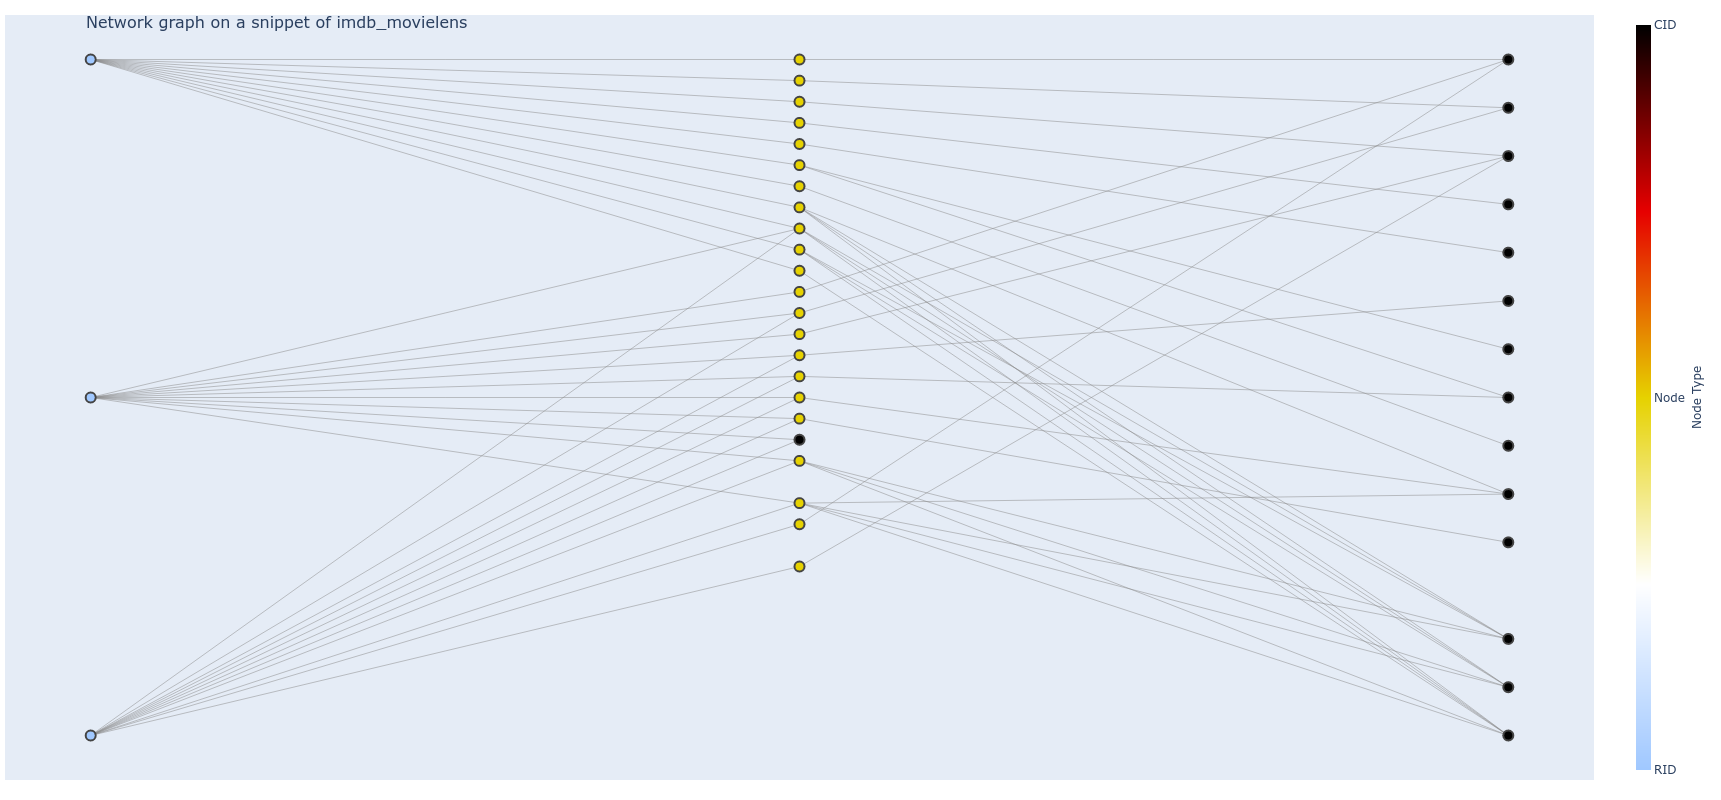

In [7]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph on a snippet of imdb_movielens',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=15),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                width=1200,
                height=800
                )
                )
fig.show()

In [16]:
# Creating a directory to save the images in. 
os.makedirs('../images', exist_ok=True)

fig.write_html('../images/testgraph.html')

## Training local embeddings on relational data using EmbDI

EmbDI is a system designed to train local embeddings on relational data. To do so, it requires a set of mandatory parameters and optional parameters to be supplied using configuration files with a specific format. 

An example of such configuration file is shown below: it will be used to train some of the embeddings used in the representation at the end of this notebook. For more info on how to prepare the configuration file, please refer to the configuration section in the readme. 

In [13]:
raw_config = '''ntop:10
ncand:1
experiment_type:ER
task:train
with_cid:all
with_rid:first
match_file:pipeline/matches/matches-imdb_movielens.txt
input_file:pipeline/datasets/imdb_movielens/imdb_movielens-master.csv
dataset_info:pipeline/info/info-imdb_movielens.txt
test_dir:
embeddings_file:pipeline/embeddings/imdb_movielens-review.embs
output_file:imdb_movielens-demo-notebook
flatten:false'''

# EmbDI is expecting a textual file, so the raw configuration is dumped in a suitable text file to be parsed by the system.

with open('pipeline/config_files/imdb_movielens-demo.txt', 'w') as fp:
    fp.write(raw_config)

Now that the configuration file is ready, the system can be ran and embeddings will be trained on the file imdb_movielens-demo-notebook.embs. The dataset currently under observation is quite large, so the training procedure will take some time. 

In [14]:
! python main.py -f pipeline/config_files/imdb_movielens-demo.txt

################################################################################
# File 1 out of 1
# Configuration file: imdb_movielens-demo.txt
# Starting run................................................ 2020-03-23 17:19:09.266067
52f4b9fc99a2418db759c04bf72ecafc
# Starting graph construction................................. 2020-03-23 17:19:10
# Flatten = False, all strings will be tokenized.
# Loading tuples in graph                                      100.0 - 49875/49875 tuples
# Normalizing node weights:                                    18.8 - 31706/168668 nodes

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Normalizing node weights:                                    56.8 - 95811/168668 nodes

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Normalizing node weights:                                    94.4 - 159292/168668 nodes

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Normalizing node weights:                                    100.0 - 168668/168668 nodes
# Graph construction complete................................. 2020-03-23 17:20:10
# Time required to build graph:............................... 59.171717
# Computing default number of sentences.
2811133 sentences will be generated.
# Skipping search of overlapping values. 
# Generating basic random walks............................... 2020-03-23 17:20:10
# Sentence generation progress: 100.0 - 2731894/2811133
# Sentence generation progress: 100.0 - 2811133/2811133
# Generation of random walks completed........................ 2020-03-23 17:34:50
# Training embeddings......................................... 2020-03-23 17:34:51.533289
File: pipeline/embeddings/imdb_movielens-review.embs
# Embeddings generation complete.............................. 2020-03-23 18:15:49
# Ending run.................................................. 2020-03-23 18:15:49.221517
# Time required: 3399.95545


## Visual representation of the embeddings

To have an idea of how embeddings encode information, it's possible to represent visually the vectors that are generated during the training phase. Normally, the dimensionality of those vectors is very high (100 or 300 dimensions), which makes it harder to notice patters. To circumvent this problem, we reduce the number of dimensions from 300 to 20 and use heatmaps to show the values of the vectors. 

In [9]:
df = pd.read_csv('pipeline/datasets/imdb_movielens/imdb_movielens-master.csv')

In [19]:
embeddings_file = '../pipeline/embeddings/imdb_movielens-demo.embs'
reduced_file = '../pipeline/experiments/imdb_movielens-demo-20.emb'

apply_PCA(embeddings_file, reduced_file, 20)

Written on file ../pipeline/experiments/imdb_movielens-demo-50.emb.


In [3]:
# Reading the reduced file
reduced_file = 'pipeline/experiments/imdb_movielens-demo-20.emb'

mat, keys = prepare_emb_matrix(reduced_file)

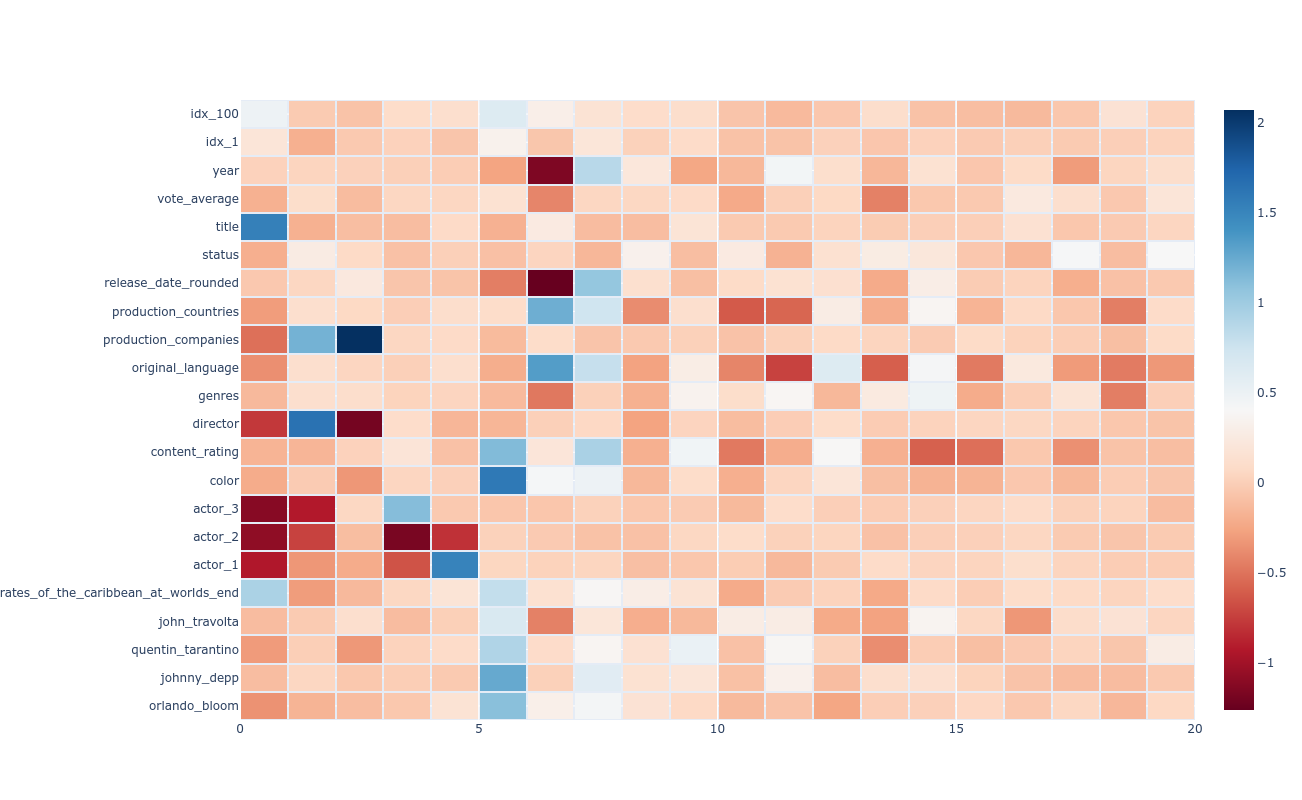

In [21]:
k = []
values = ['orlando_bloom', 'johnny_depp', 'quentin_tarantino', 'john_travolta', 'pirates_of_the_caribbean_at_worlds_end']
values += list(df.columns)
values += ['idx_1', 'idx_100']
for _ in values:
    k.append(keys.index(_))

hmap_trace = go.Heatmap(z=mat[k,:], x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200, height=800))
fig.show()
fig.write_html('../images/heatmap.html')

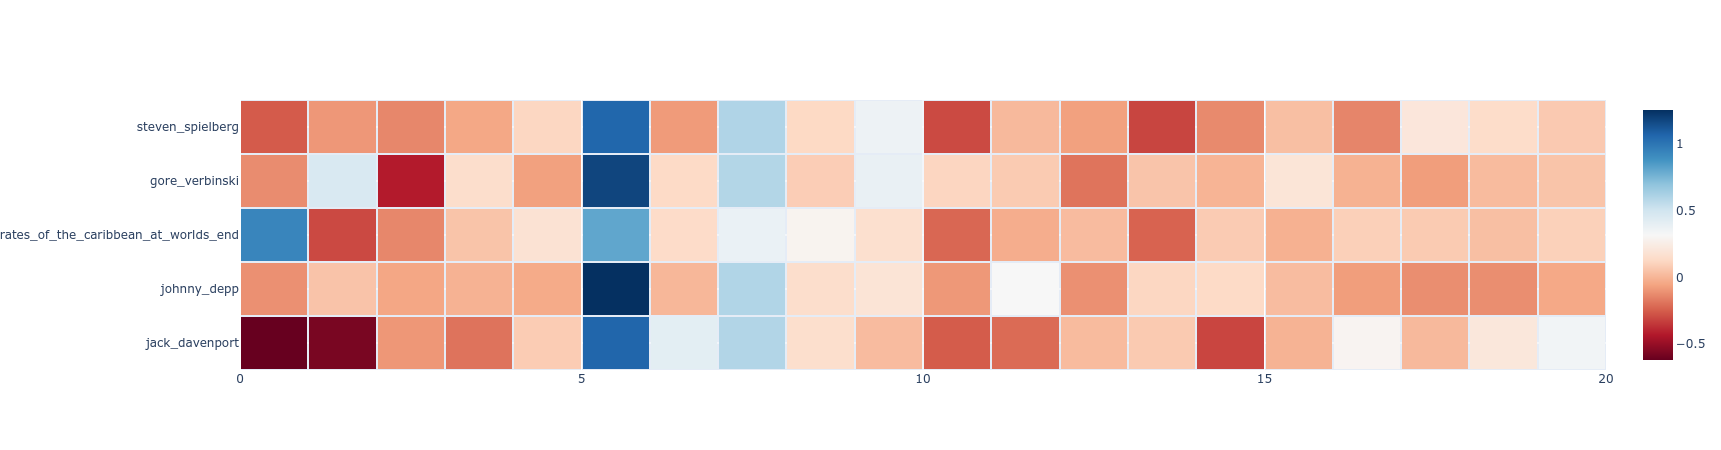

In [266]:
values = ['jack_davenport', 'johnny_depp', 'pirates_of_the_caribbean_at_worlds_end',  'gore_verbinski', 'steven_spielberg']
k = []
for _ in values:
    k.append(keys.index(_))

hmap_trace = go.Heatmap(z=mat[k,:], x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200))
fig.show()
fig.write_html('../images/heatmap2.html')

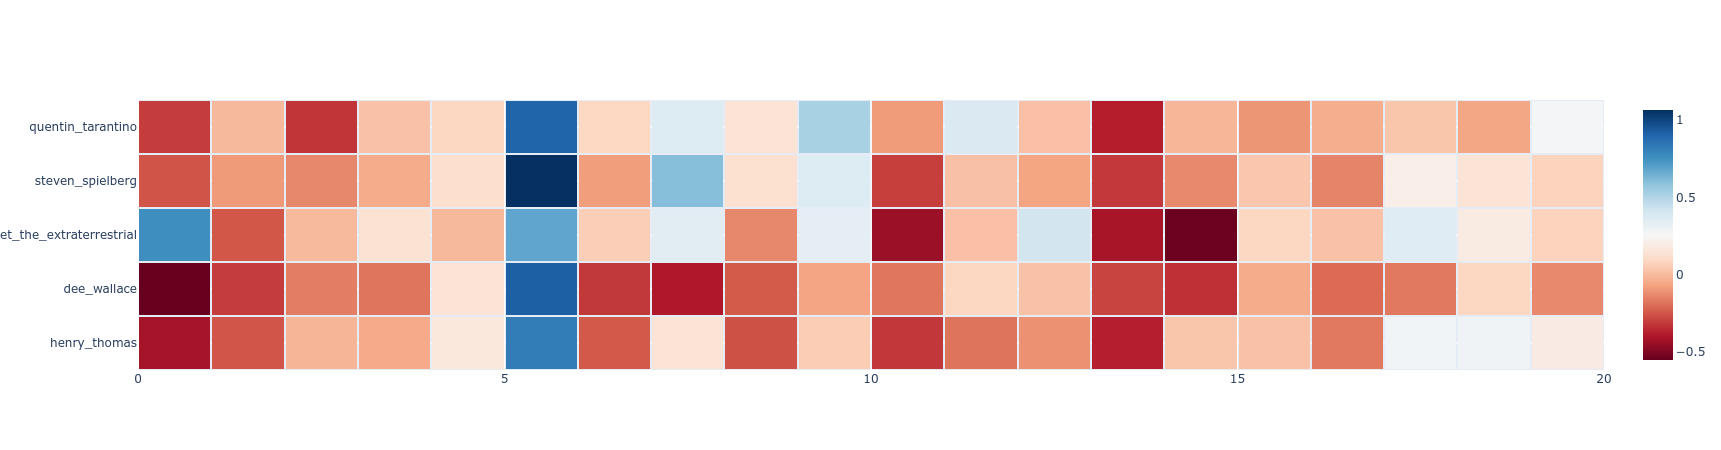

In [22]:
values = ['henry_thomas', 'dee_wallace', 'et_the_extraterrestrial',  'steven_spielberg', 'quentin_tarantino']
k = []
for _ in values:
    k.append(keys.index(_))

hmap_trace = go.Heatmap(z=mat[k,:], x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200))
fig.show()
fig.write_html('../images/heatmap2.html')
fig.write_image('../images/heatmap2.png')

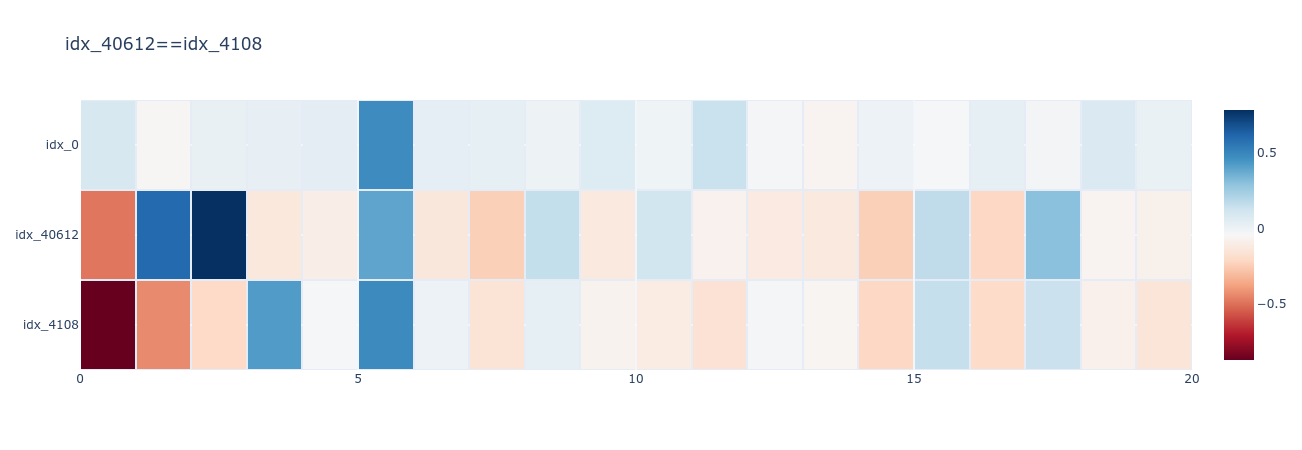

In [23]:
values = ['idx_4108', 'idx_40612', 'idx_0']
k = []
for _ in values:
    k.append(keys.index(_))

hmap_trace = go.Heatmap(z=mat[k,:], x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200, title='idx_40612==idx_4108'))
fig.show()
fig.write_html('../images/heatmap3.html')
fig.write_image('../images/heatmap3.png')

In [202]:
embeddings_file = '../pipeline/experiments/movielens-demo.embs'
reduced_file = '../pipeline/experiments/movielens-demo-20.emb'

apply_PCA(embeddings_file, reduced_file, 20)

Written on file ../pipeline/experiments/movielens-demo-20.emb.


In [24]:
reduced_file = '../pipeline/experiments/movielens-demo-20.emb'
keys = []
with open(reduced_file, 'r') as fp:
    lines = fp.readlines()

    sizes = lines[0].split()
    sizes = [int(_) for _ in sizes]

    mat = np.zeros(shape=sizes)
    for n, line in enumerate(lines[1:]):
        ll = line.strip().split()
        mat[n, :] = np.array(ll[1:])
        keys.append(ll[0])

In [26]:
df1 = pd.read_csv('../pipeline/datasets/imdb_movielens/movielens_nospace.csv')

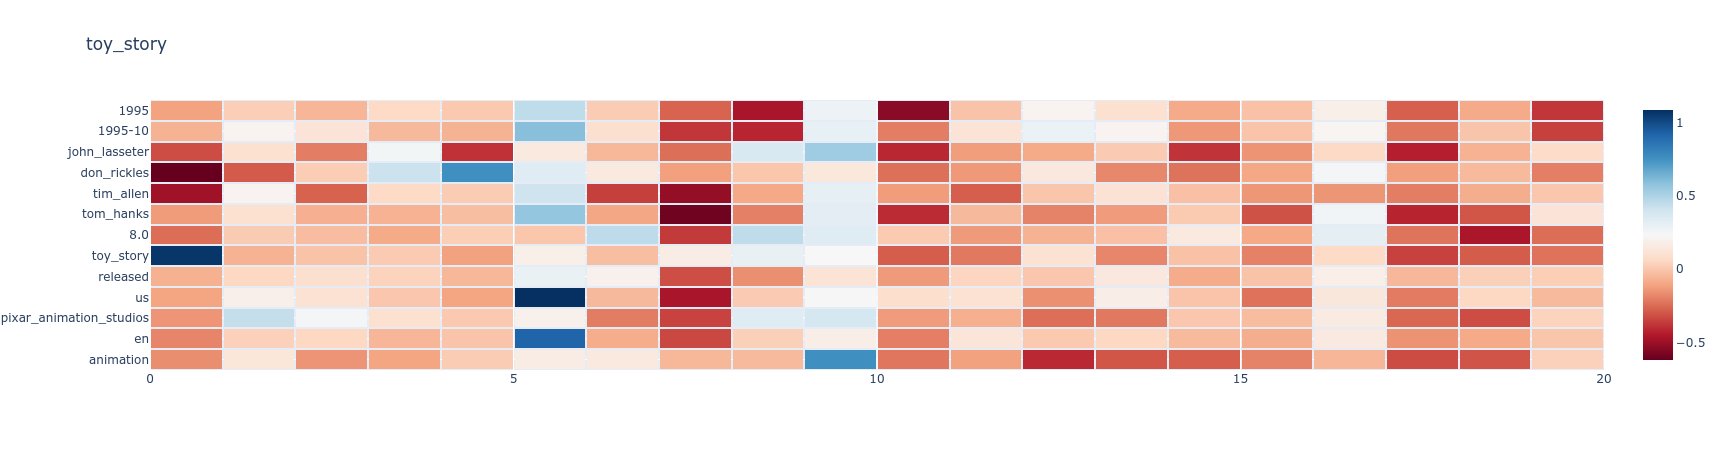

In [27]:
values = [str(_) for _ in df1.loc[0].values.tolist()]
k = []
for _ in values:
    k.append(keys.index(_))

hmap_trace = go.Heatmap(z=mat[k,:], x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200, title='toy_story'))
fig.show()
fig.write_html('../images/toy_story.html')
fig.write_image('../images/toy_story.png')

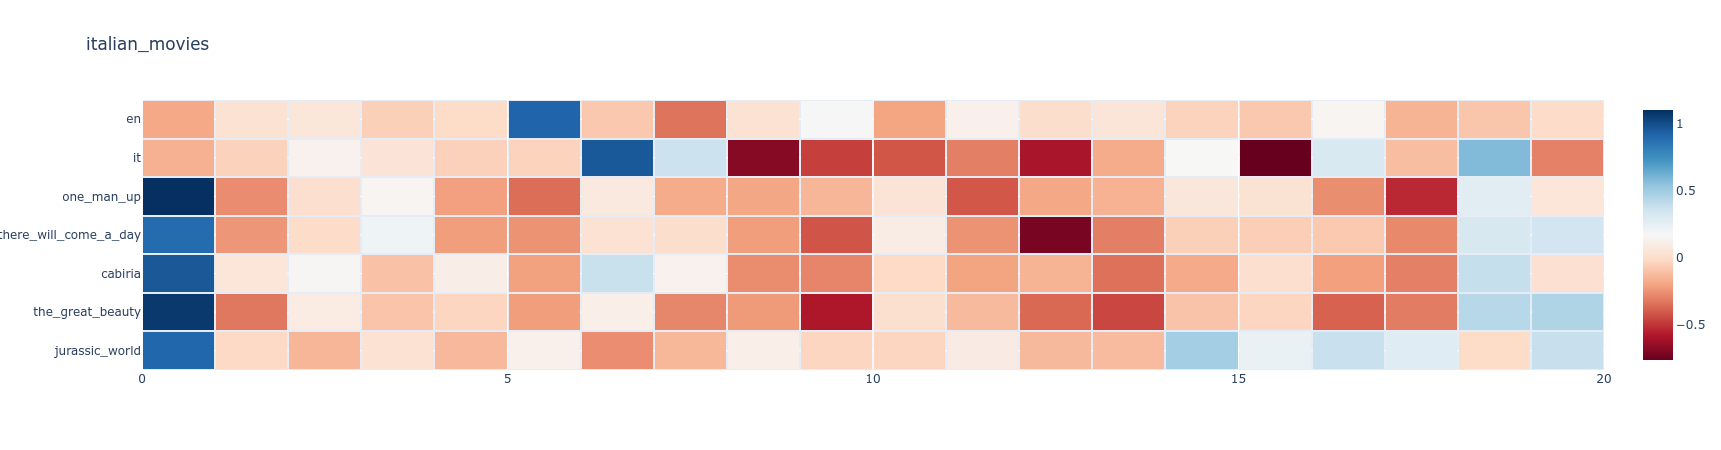

In [29]:
values = ['jurassic_world','the_great_beauty', 'cabiria', 'there_will_come_a_day', 'one_man_up', 'it', 'en']

k = []
for _ in values:
    k.append(keys.index(_))

hmap_trace = go.Heatmap(z=mat[k,:], x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200, title='italian_movies'))
fig.show()
fig.write_html('../images/italian_movies.html')
fig.write_image('../images/italian_movies.png')

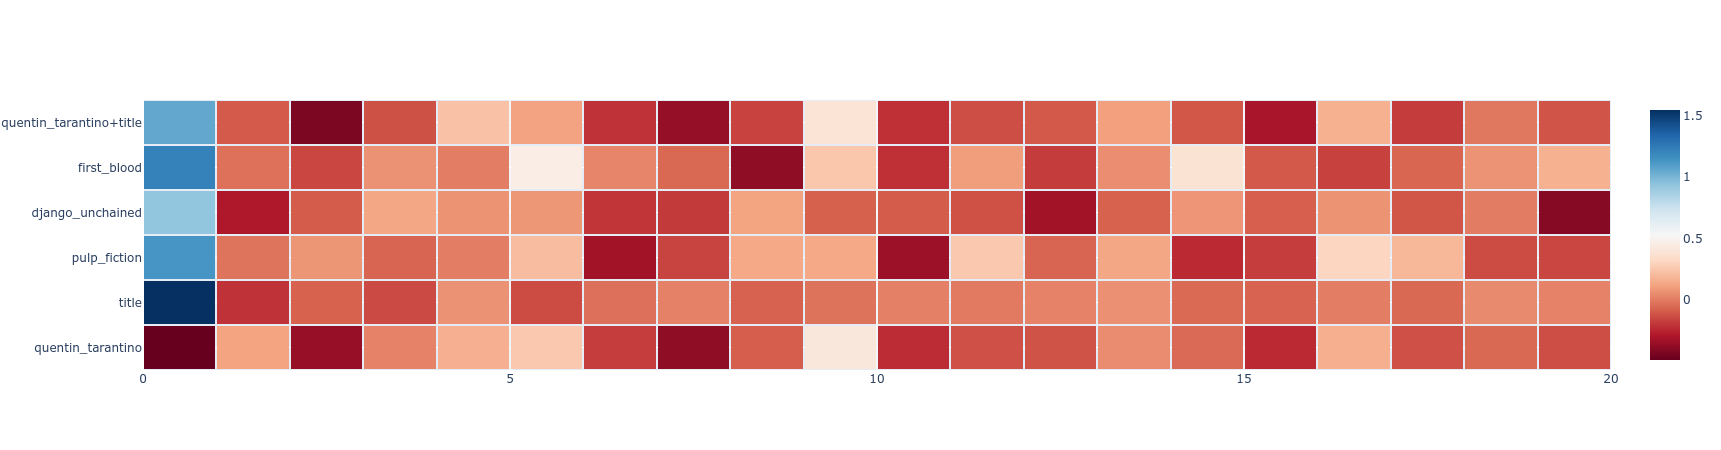

In [31]:
values = ['quentin_tarantino','title', 'pulp_fiction', 'django_unchained', 'first_blood']


k = []
for _ in values:
    k.append(keys.index(_))

m = mat[k,:]

array_title = mat[keys.index('title')]
array_director_name = mat[keys.index('quentin_tarantino')]
array_sum = array_title+array_director_name

m = np.concatenate((m, array_sum.reshape((1,20))), axis=0)
values.append('quentin_tarantino+title')

hmap_trace = go.Heatmap(z=m, x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200, title=''))
fig.show()
fig.write_html('../images/sum_of_vectors.html')
fig.write_image('../images/sum_of_vectors.png')


In [249]:
embeddings_file = '../pipeline/embeddings/imdb_movielens-sm-demo.embs'
reduced_file = '../pipeline/experiments/imdb_movielens-sm-demo-20.emb'

apply_PCA(embeddings_file, reduced_file, 20)

In [32]:
reduced_file = '../pipeline/experiments/imdb_movielens-sm-demo-20.emb'
keys = []
with open(reduced_file, 'r') as fp:
    lines = fp.readlines()

    sizes = lines[0].split()
    sizes = [int(_) for _ in sizes]

    mat = np.zeros(shape=sizes)
    for n, line in enumerate(lines[1:]):
        ll = line.strip().split()
        mat[n, :] = np.array(ll[1:])
        keys.append(ll[0])

In [33]:
model_file = reduced_file
# model_file = '../pipeline/experiments/movielens-demo-noidx.emb'
model = models.KeyedVectors.load_word2vec_format(model_file, unicode_errors='ignore')

df1 = pd.read_csv('../pipeline/datasets/imdb_movielens/imdb_movielens-master-sm.csv')

/home/spoutnik23/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.



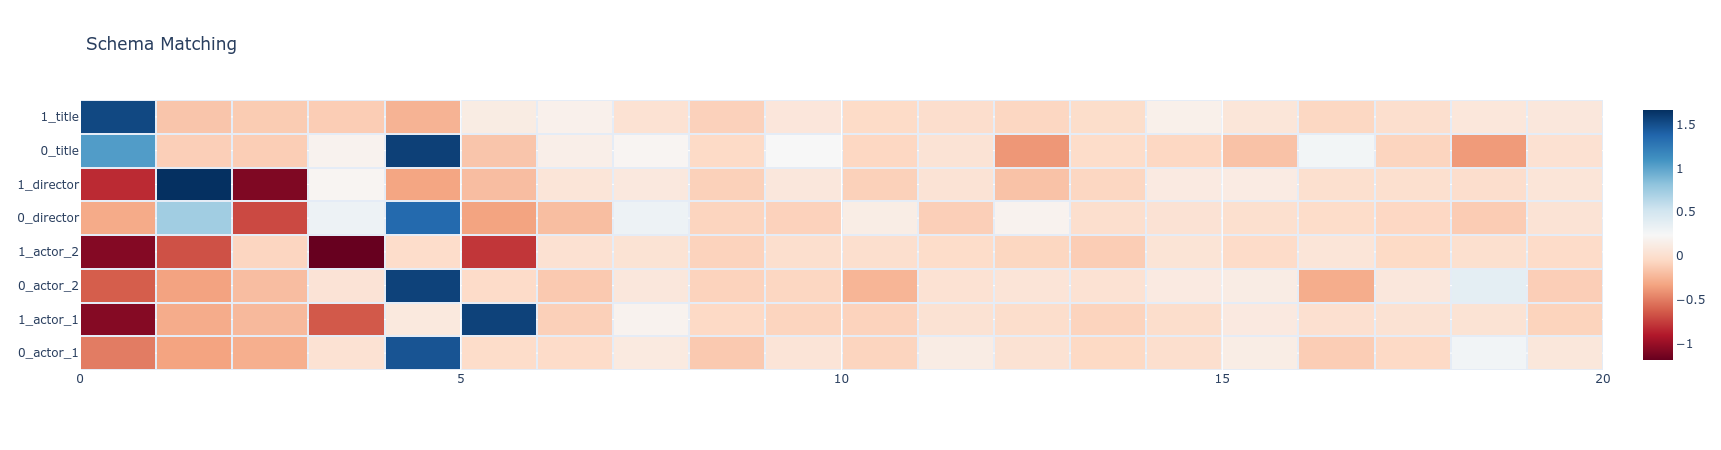

In [34]:
values = ['0_actor_1','1_actor_1', '0_actor_2', '1_actor_2', '0_director', '1_director', '0_title', '1_title']
# values = ['the_great_beauty'] + mm + ['it']

k = []
for _ in values:
    k.append(keys.index(_))

hmap_trace = go.Heatmap(z=mat[k,:], x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200, title='Schema Matching'))
fig.show()
fig.write_html('../images/schema_matching_movies.html')
fig.write_image('../images/schema_matching_movies.png')


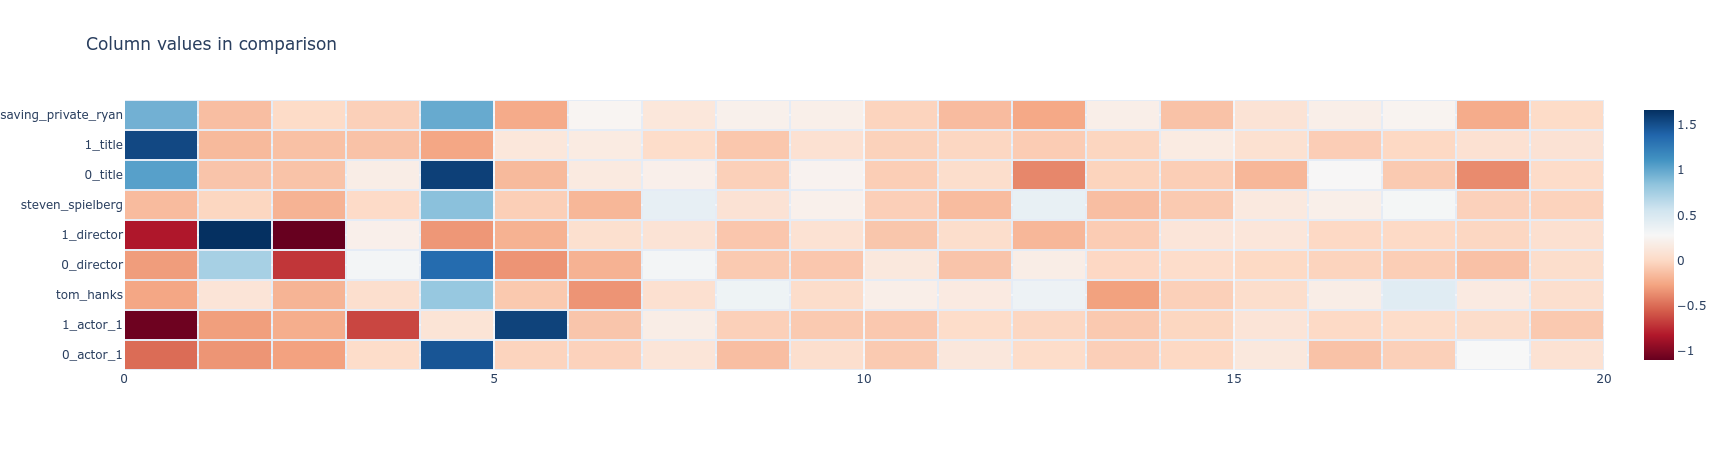

In [36]:
values = ['0_actor_1','1_actor_1', 'tom_hanks', '0_director', '1_director','steven_spielberg', '0_title', '1_title', 'saving_private_ryan']
# values = ['the_great_beauty'] + mm + ['it']

k = []
for _ in values:
    k.append(keys.index(_))

hmap_trace = go.Heatmap(z=mat[k,:], x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200, title='Column values in comparison'))
fig.show()
fig.write_html('../images/values_with_columns.html')
fig.write_image('../images/values_with_columns.png')

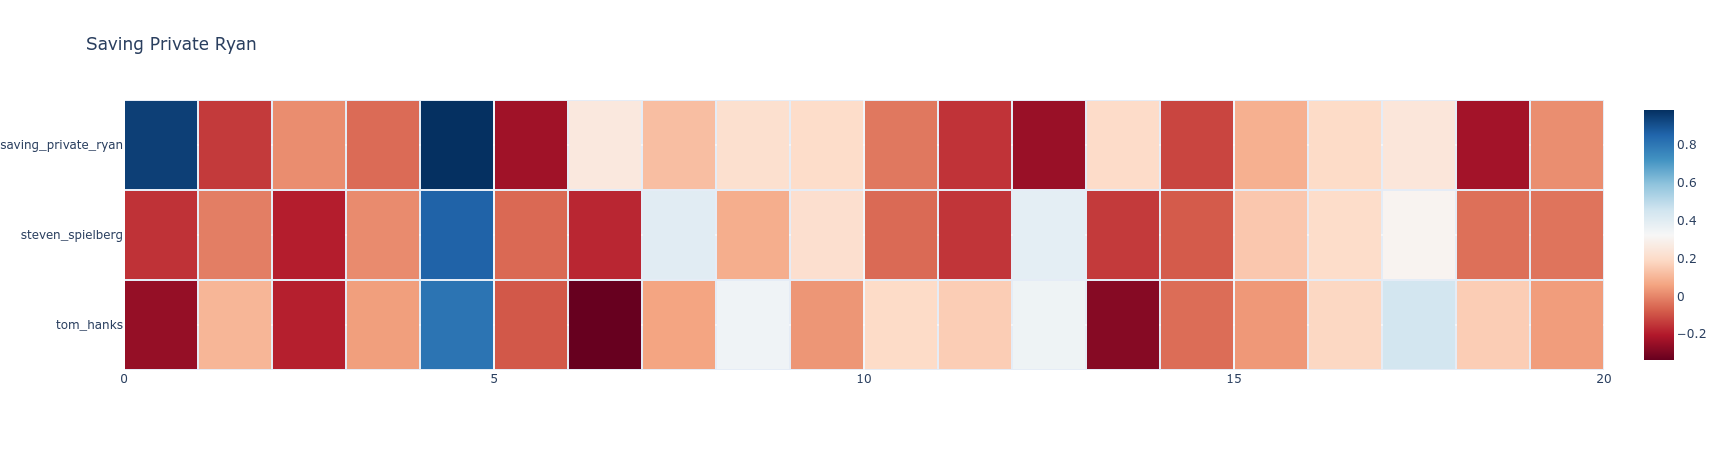

In [37]:
values = ['tom_hanks', 'steven_spielberg', 'saving_private_ryan']
# values = ['the_great_beauty'] + mm + ['it']

k = []
for _ in values:
    k.append(keys.index(_))

hmap_trace = go.Heatmap(z=mat[k,:], x=np.arange(50), y=values, colorscale='RdBu', xgap=2, ygap=2)
fig = go.Figure(data=[hmap_trace], layout=dict(width=1200, title='Saving Private Ryan'))
fig.show()
fig.write_html('../images/saving_private_ryan.html')
fig.write_image('../images/saving_private_ryan.png')